# Imports

In [1]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

Reading XAMS data from pickles...
Read data in 37.21 seconds


In [2]:
import pandas as pd
from tqdm import tqdm

In [3]:
data_dir = '/data/xenon/ehogenbi/pulsefit/processing_pickles'

# Functions

## Reading

In [4]:
import re

In [5]:
def read_pickles(dirname, base_name, max_i = None):
    if max_i is None:
        fns = os.listdir(dirname)
        fns = [os.path.join(dirname, fn) for fn in fns if re.match(base_name + '_....pickle', fn)]#if base_name in fn]
        fns = np.sort(fns)
    else:
        fns = [os.path.join(dirname, base_name + '_%03d.pickle' % i) for i in range(max_i)]
    if len(fns) == 0:
        print('Found no filenames for base %s, skipping...' % base_name)
        return pd.DataFrame([])
    dicts = []
    for fn in fns:
        with open(fn, 'rb') as f:
            dicts.append(pickle.load(f))
    dicts =  np.concatenate(dicts)
    df = pd.DataFrame(list(dicts))
    if df.isnull().values.any():
        print('Warning: found some NaNs or Nones in the dataframe. Maybe check your computation results?')
    if 'chi2' not in df.keys():
        print('Warning: found no chi2 for %s. Are you reading unprocessed files?' % (base_name))
    print('Read %d datapoints from %d files.' % (len(df), len(fns)))
    if 'stored_stat' in df.keys():
        # Brainfart when I put this in
        df['stored_stat_value'] = df['stored_stat']
        df['stored_stat'] = True
    return df



In [6]:
def round_df(df, decimals = 3):
    '''Round all non-str values of the dataframe to string ones.'''
    for key in df.keys():
        if type(df[key].iloc[0]) == str:
            continue
        df[key] = np.round(df[key], decimals)
    return df

def remove_common(df1, df2, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Remove all the elements in df1 that are already in df2 (comparing the keys in key_list)
    '''
    df1_sub = deepcopy(df1[key_list])
    df2_sub = deepcopy(df2[key_list])
    df1_sub = round_df(df1_sub)
    df2_sub = round_df(df2_sub)
    mask = np.invert(pd.concat([df1_sub,df2_sub]).duplicated(keep=False).values[:len(df1_sub)])
    print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df1)))
    df1 = df1[mask]
    df1 = df1.reset_index(drop=True)
    return df1

In [7]:
def read_and_combine(dirname, list_of_base, remove_duplicates = True, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Read dataframes with different base_name, merge dataframes and remove duplicates.
    '''
    df_list = []
    for base_name in list_of_base:
        df_list.append(read_pickles(dirname, base_name))
    df = pd.concat(df_list)
    df_keys = deepcopy(df[key_list])
    df_keys = round_df(df_keys)
    mask = np.invert(df_keys.duplicated().values)
    if sum(np.invert(mask)) > 0:
        print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df)))
    # Reset the index after concatenating
    df = df.reset_index(drop=True)
    return df

In [8]:
def read_energy_bins(data_dir, base_name, e_bins):
    '''
    Read all datasets.
    Returns list of dataframes
    '''
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_pickles(data_dir, base_name + '_%02d_%02d' % (e_min, e_max))
        ddf.append(df)
    return ddf

In [9]:
def read_and_combine_energy_bins(data_dir, base_names, e_bins):
    ddf = []
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_and_combine(data_dir, [base_name + '_%02d_%02d' % (e_min, e_max) for base_name in base_names])
        ddf.append(df)
    return ddf

## Plotting

In [10]:
def parslice_2d(df, x, y, key = 'chi2', plot_min = True, vmax=None, **kwargs):
    '''
    Plot the minimum values of chi2 for two variables (i.e. a projection of the minimum onto the 2d slice)
    '''
    dfmin = df.sort_values(by=key).iloc[0]
    if vmax is None:
        vmax = dfmin['chi2'] * 1.5
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    plt.scatter(grouped[x], grouped[y], c= grouped[key], vmax = vmax, **kwargs)
    plt.colorbar(label='chi2/ndf')
    if plot_min:
        plt.scatter(dfmin[x], dfmin[y], color='red', marker='+', s = 500)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [11]:
def plot_all_slices(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    for x, y in zip(['t3', 't1', 't1'], ['fs', 'tts', 't3']):
        parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [12]:
def plot_slice_containing_point(df, x, y, row, **kwargs):
    df_sel = deepcopy(df)
    for key in row.keys():
        if (key == x) or (key == y) or (key=='chi2'):
            continue
        df_sel = df_sel[df_sel[key] == row[key]]
    plt.scatter(df_sel[x], df_sel[y], c= df_sel['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

## Minimum stability

In [13]:
def get_some_minima(df, n_values=None, threshold=None, key='chi2'):
    '''
    Get the minimum n points of the dataframe up to chi2 value specified by threshold.
    If threshold is None, just take n values.
    If n_values is None, no restriction on the number of points.
    This function may be used to get the statistical error, although perhaps tricky how.
    Maximum deviation? std? 
    '''
    if threshold is None:
        selected_minima = df.sort_values(by = key)
    else:
        selected_minima = df.sort_values(by = key)[:n_values]
    if threshold is not None:
        selected_minima = selected_minima[selected_minima[key] <= threshold]
    print('Selected %d values with %s ranging from %.2f to %.2f...' % (len(selected_minima), 
                                                                       key,
                                                                         selected_minima[key].min(),
                                                                        selected_minima[key].max()))
    return deepcopy(selected_minima)

In [102]:
def scan_settings_and_get_min(x, df):
    '''
    x is a list of settings dicts, which may be produced by produce_settings_dict
    '''
    result = []
    for settings in tqdm(x):
        chi2 = recompute_chi2(df, **settings)
        minval = df.iloc[np.argmin(chi2)]
        minval = deepcopy(minval) # to shut up pandas
        minval = strip_junk(minval)
        minval['chi2'] = np.min(chi2)
        minval = merge_two_dicts(minval, settings)
        result.append(minval)
    return pd.DataFrame(result)

In [15]:
def check_minima(df, n_values, check_times):
    '''
    Take n minimum values, recompute them, take the mean and see if the minimum is still the minimum.
    '''
    electa = get_some_minima(df, n_values)
    electa['ranking_before'] = range(len(electa))
    chi2_new = []
    for index, settings in electa.iterrows():
        print('Working on setting %d' % index)
        settings = deepcopy(dict(settings))
        settings = strip_junk(settings)
        gofs = [gof(**settings) for _ in range(check_times)]
        chi2_new.append(np.average(gofs))
    electa['chi2_new_%d_times' % check_times] = chi2_new
    electa = electa.sort_values(by = 'chi2_new_%d_times' % check_times)
    electa['ranking_after'] = range(len(electa))
    electa = electa.sort_values(by='chi2')
    changed = electa['ranking_before'] != electa['ranking_after']
    if sum(changed) != 0:
        print('Warning: I detected a changing order!')
    return electa


In [16]:
def print_minima(mins):
    print('Giving the standard deviation for %d points...' % len(mins))
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f +- %.3f" % (key, np.average(mins[key]), np.std(mins[key])))
    print('Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for %d points...' % len(mins))
    bestfit = mins.sort_values(by='chi2').iloc[0]
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f + %.3f - %.3f" % (key, bestfit[key],
                                            bestfit[key] - np.min(mins[key]),
                                            np.max(mins[key]) - bestfit[key]
                                           ))
    return

In [17]:
def recompute_chi2(df, **p):
    '''
    Recompute chi2 with new settings given in p.
    Parameters will be passed to `gof_manual`.
    '''
    chi2_new = []
    for i, row in df.iterrows():
        p2 = merge_two_dicts(dict(row), p)
        chi2_new.append(gof_manual(verbose=False, **p2))
    return np.array(chi2_new)

In [18]:
def minvalue(df, key='chi2', to_input = False, keep_only_stored = False):
    '''
    Take the value where minimum occurs
    '''
    minrow = df.iloc[df[key].argmin()]
    minrow = dict(minrow)
    if to_input:
        # Prepare to input into recomputing
        return minrow
    else:
        if not keep_only_stored:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray)}
        else:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray or k is 'stored_stat_value')}
        return minrow

In [19]:
def build_fine_grid(df, n_values_min, keys, current_step_size, increase_factor = 2):
    mins = get_some_minima(df, n_values_min)
    all_points = []
    for _, minval in mins.iterrows():
        neighbours = produce_settings_dicts(keys, 
                               [minval[key] - current_step_size[i] for i, key in enumerate(keys)],
                               [minval[key] + current_step_size[i] for i, key in enumerate(keys)],
                               [1/increase_factor * current_step_size[i] for i in range(len(current_step_size))],
                                np.inf
                              )
        all_points.append(neighbours)
    all_points = np.concatenate(all_points)
    all_unique_points = [dict(t) for t in set([tuple(d.items()) for d in all_points])]
    print('Removed %d of %d settings that were nonunique, %d left...' % (len(all_points) - len(all_unique_points),
                                                                         len(all_points), len(all_unique_points)))
    good_points = [d for d in all_unique_points if ((d['t1'] > 1e-3) and (d['tts'] > 1e-3))]
    print('Also removed %d points with zero t1 or tts, %d left!' % (len(all_unique_points) - len(good_points),
                                                                   len(good_points)))
    return good_points

In [20]:
def strip_junk(dic):
    dic['stored_stat_value'] = dic['stored_stat']
    dic = {k : v for k, v in dic.items() if (type(v) is not np.ndarray) or k == 'stored_stat_value' }
    return dic

## Placeholder

In [21]:
print('Done!')

Done!


In [ ]:
# Run all above from this cell

# Reading results

### Statistical errors, fine grid production

In [250]:
mins = get_some_minima(df, 20)
print_minima(mins)

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Giving the standard deviation for 20 points...
fs = 0.237 +- 0.010
t3 = 21.700 +- 0.458
t1 = 1.625 +- 0.444
tts = 1.512 +- 0.185


In [251]:
fine = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.0125, 0.5, 0.5, 0.25])

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Removed 6699 of 12500 settings that were nonunique, 5801 left...
Also removed 0 points with zero t1 or tts, 5801 left!


In [252]:
df_fine = pd.DataFrame(fine)

In [253]:
np.diff(np.unique(df['fs']))

array([ 0.0125,  0.0125,  0.0125,  0.0125])

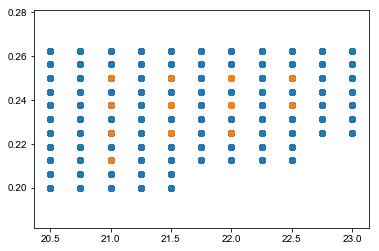

In [254]:
plt.scatter(df_fine['t3'], df_fine['fs'])
plt.scatter(mins['t3'], mins['fs'])
plt.show()

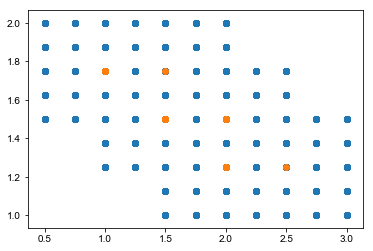

In [255]:
plt.scatter(df_fine['t1'], df_fine['tts'])
plt.scatter(mins['t1'], mins['tts'])
plt.show()

In [256]:
pickle.dump(fine, open('/data/xenon/ehogenbi/pulsefit/pickles/nr_finegrid.pickle', 'wb'))

### Systematic uncertainties

In [257]:
syst_settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], [-16, 100, 0], [-4, 150, 2e-4], [4, 10, 1e-4], 
                                   block_size = np.inf)

Loaded 72 settings.


In [258]:
mins = scan_settings_and_get_min(syst_settings, df)

100%|██████████| 72/72 [01:22<00:00,  1.09s/it]


In [259]:
print_minima(mins)

Giving the standard deviation for 72 points...
fs = 0.235 +- 0.010
t3 = 21.549 +- 0.207
t1 = 1.583 +- 0.400
tts = 1.458 +- 0.200


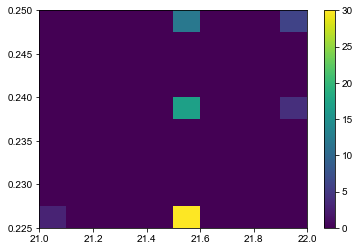

In [260]:
plt.hist2d(mins['t3'], mins['fs'])
plt.colorbar()
plt.show()

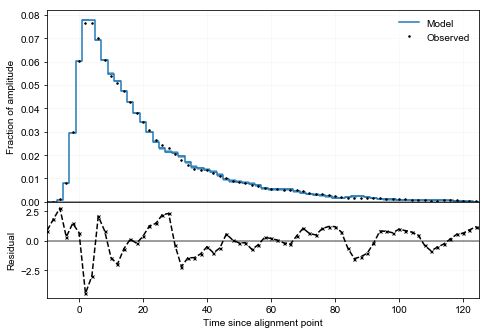

chi2 = 1.505357


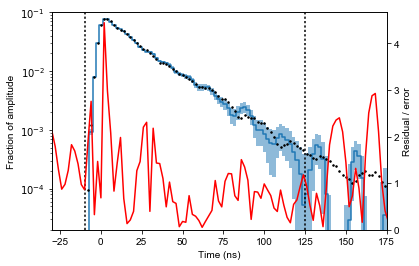

In [22]:
p = minvalue(df, key='chi2', to_input=True)
plot_model(verbose = False, **p)

In [25]:
minvalue(df)

{'chi2': 1.5359936092275124,
 'dset': 'nr',
 'fs': 0.23749999999999999,
 't1': 1.5,
 't3': 21.5,
 'tts': 1.5}

## ER energy scan

In [44]:
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
ddf = read_energy_bins(data_dir, 'er', e_bins_er)

In [46]:
# ddf = read_energy_bins(data_dir, 'er', e_bins_er)

Read 6237 datapoints from 12 files.
Read 6237 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.


In [357]:
df = ddf[2]

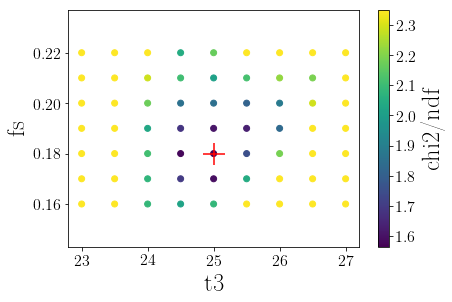

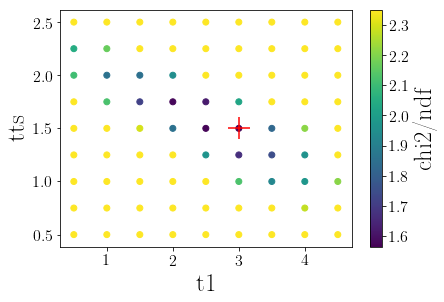

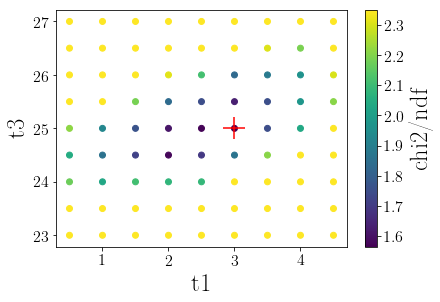

In [358]:
plot_all_slices(df)

In [323]:
df.loc[df['chi2'].argmin()]


chi2                                                           1.93649
dset                                                              er_l
e_max                                                               50
e_min                                                               30
fs                                                                0.06
model                [5.18171797324e-05, 7.03460720681e-05, 7.81458...
n_photons                                                      2000000
spe_err              [1.07950389131e-05, 1.26881648048e-05, 1.40484...
stored_stat                                                       True
syst_err             [1.14399607894e-06, 6.47591504168e-07, 3.21523...
t1                                                                   1
t3                                                                  26
tts                                                               1.75
ydata                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
stored

In [319]:
df['chi2'].argmin()

2720

In [316]:
df['chi2'].argmin()

2720

In [317]:
df[2720:2730]

,chi2,dset,e_max,e_min,fs,model,n_photons,spe_err,stored_stat,syst_err,t1,t3,tts,ydata,stored_stat_value
2720,128.904276,er_l,50,30,0.16,"[5.19912363617e-05, 8.80484257454e-05, 0.00010...",2000000,"[1.25165714205e-05, 1.52049683053e-05, 1.67229...",True,"[2.43175795514e-06, 1.22899343199e-06, 2.86955...",2.5,23.5,1.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2721,116.697030,er_l,50,30,0.16,"[5.22330346294e-05, 8.5962070875e-05, 0.000100...",2000000,"[1.21583694661e-05, 1.49294612492e-05, 1.64971...",True,"[2.2755478663e-06, 1.07867982226e-06, 2.809445...",2.5,23.5,1.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2722,111.385494,er_l,50,30,0.16,"[5.20977115434e-05, 8.39438074014e-05, 9.89806...",2000000,"[1.18302130287e-05, 1.4651455932e-05, 1.628627...",True,"[2.17106344259e-06, 9.64353974319e-07, 2.66812...",2.5,23.5,1.50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2723,103.426418,er_l,50,30,0.16,"[5.19178338661e-05, 8.17520563278e-05, 9.74288...",2000000,"[1.15374665095e-05, 1.4392405001e-05, 1.609060...",True,"[1.77569639766e-06, 5.48961666667e-07, 2.69920...",2.5,23.5,1.75,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2724,90.630918,er_l,50,30,0.16,"[5.14880152917e-05, 7.94940503401e-05, 9.56583...",2000000,"[1.12385612993e-05, 1.40885815399e-05, 1.58416...",True,"[1.76829244351e-06, 5.3639044423e-07, 2.554712...",2.5,23.5,2.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2725,83.596681,er_l,50,30,0.16,"[5.10020751674e-05, 7.75448443771e-05, 9.39974...",2000000,"[1.10302257313e-05, 1.38455956183e-05, 1.56648...",True,"[1.5782878093e-06, 4.03053841161e-07, 2.382640...",2.5,23.5,2.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2726,73.889717,er_l,50,30,0.16,"[5.0317709154e-05, 7.53978496956e-05, 9.196509...",2000000,"[1.07929568017e-05, 1.35490820858e-05, 1.54004...",True,"[1.25711868466e-06, 1.75782245989e-07, 2.36277...",2.5,23.5,2.50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2727,138.940453,er_l,50,30,0.16,"[5.17497628463e-05, 9.03719965416e-05, 0.00010...",2000000,"[1.3014283833e-05, 1.55341855599e-05, 1.703125...",True,"[2.67114759514e-06, 1.38806007395e-06, 3.07425...",3.0,23.5,0.50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2728,134.578876,er_l,50,30,0.16,"[5.22038675684e-05, 8.91141922446e-05, 0.00010...",2000000,"[1.26959164811e-05, 1.52986597034e-05, 1.68314...",True,"[2.62069887143e-06, 1.27874551395e-06, 3.09345...",3.0,23.5,0.75,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2729,127.232272,er_l,50,30,0.16,"[5.24974048876e-05, 8.73675655e-05, 0.00010037...",2000000,"[1.23865201325e-05, 1.50390147448e-05, 1.66044...",True,"[2.32340395484e-06, 1.03712231099e-06, 2.88557...",3.0,23.5,1.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [324]:
minvalue(df)

{'chi2': 1.9364905343988852,
 'dset': 'er_l',
 'e_max': 50,
 'e_min': 30,
 'fs': 0.059999999999999998,
 'n_photons': 2000000,
 'stored_stat': True,
 't1': 1.0,
 't3': 26.0,
 'tts': 1.75}

In [63]:
p = minvalue(df, to_input=True)

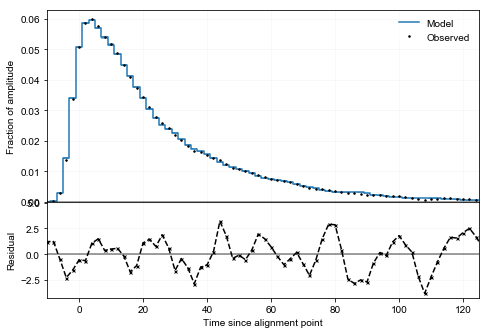

chi2 = 2.467576


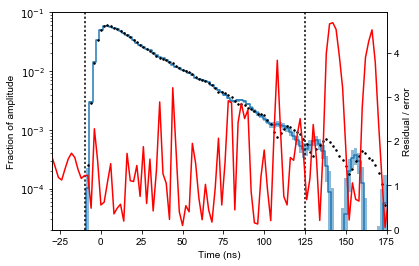

In [64]:
plot_model_manual(**p)

In [65]:
ddf = []
for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
    df = read_pickles(data_dir, 'er_%02d_%02d' % (e_min, e_max))
    ddf.append(df)

Read 6237 datapoints from 12 files.
Read 6237 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.


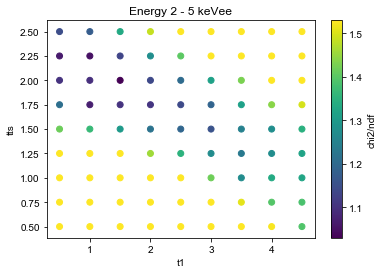

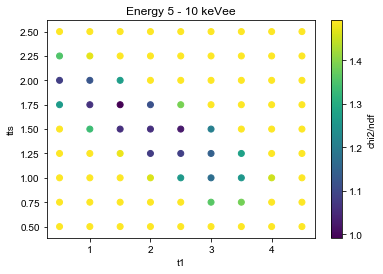

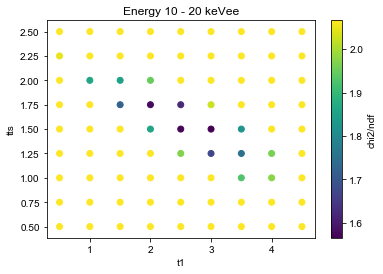

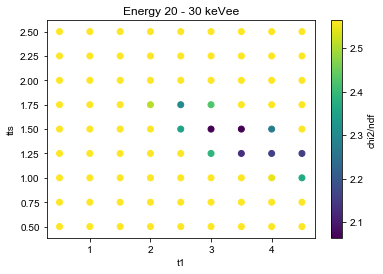

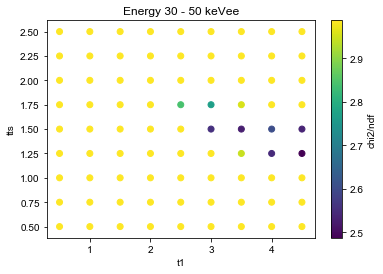

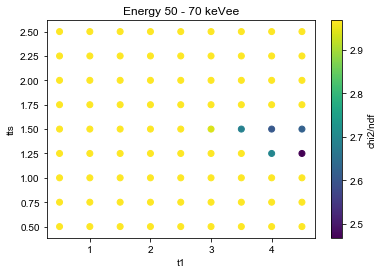

In [226]:
for i, df in enumerate(ddf):
    # plt.ylim(20, 28)
    plt.title('Energy %d - %d keVee' % (df.iloc[0]['e_min'], df.iloc[0]['e_max']))
    parslice_2d(df, 't1', 'tts', vmax=df['chi2'].min() + 0.5)
    

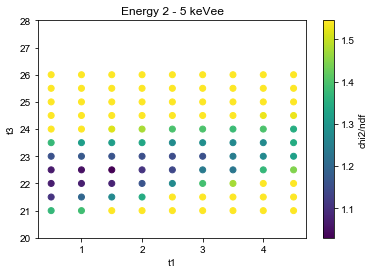

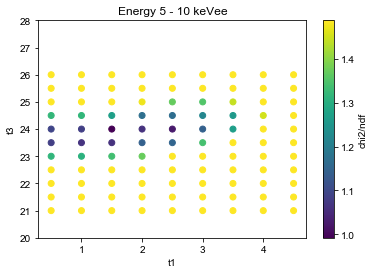

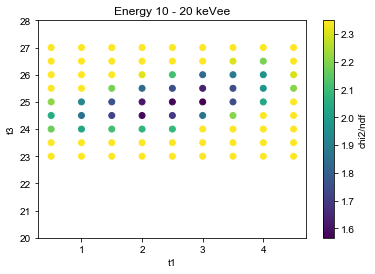

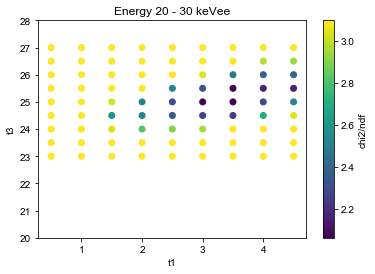

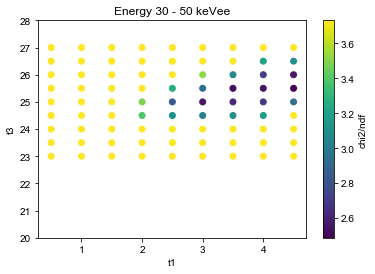

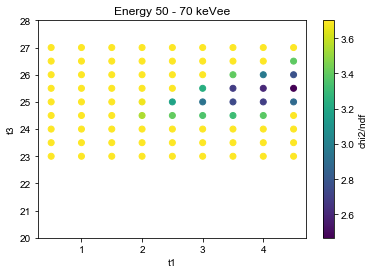

In [222]:
for i, df in enumerate(ddf):
    plt.ylim(20, 28)
    plt.title('Energy %d - %d keVee' % (df.iloc[0]['e_min'], df.iloc[0]['e_max']))
    parslice_2d(df, 't1', 't3', vmax=df['chi2'].min() * 1.5)

In [76]:
min_per_e = deepcopy(pd.DataFrame([df.sort_values(by='chi2').iloc[0] for df in ddf]))

In [77]:
min_per_e['e'] = 0.5 * (min_per_e['e_max'] + min_per_e['e_min'])

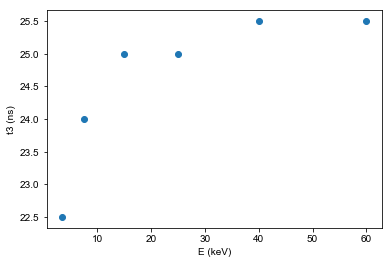

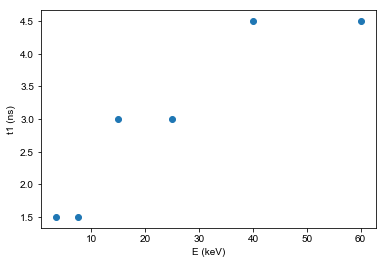

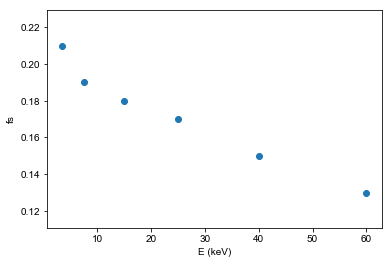

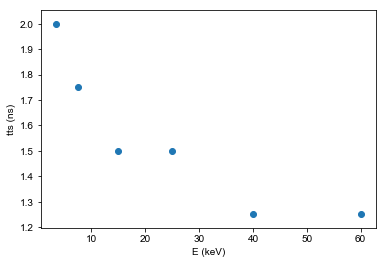

In [227]:
plt.scatter(min_per_e['e'], min_per_e['t3'])
plt.xlabel('E (keV)')
plt.ylabel('t3 (ns)')
plt.show()

plt.scatter(min_per_e['e'], min_per_e['t1'])
plt.xlabel('E (keV)')
plt.ylabel('t1 (ns)')
plt.show()

plt.scatter(min_per_e['e'], min_per_e['fs'])
plt.xlabel('E (keV)')
plt.ylabel('fs')
plt.show()

plt.scatter(min_per_e['e'], min_per_e['tts'])
plt.xlabel('E (keV)')
plt.ylabel('tts (ns)')
plt.show()


For higher energy ER, we see a clear shift to higher livetimes for both the short and the long livetimes. This is probably due to increased recombination times. Especially in t1 this is quite clear: the distribution gets quite wide to the right side of the distribution, maybe even a 'second bump'... This would probably mean that high energy ERs create a longer track, increasing the recombination time. So, in this case, the ionization density INcreases for low energy ER recoils, making them more comparable to NRs. (Note: this is true (Chepel, Aruyo).)

Incidentally, the transit time spread decreases with E since this counteracts t1...?

Maybe the following:
  * Check NR. Is it purely the two exponentials? (Maybe it is..)

## NR energy scan

In [48]:
e_bin_i = 2

In [49]:
e_bins_nr = [2, 5, 10, 15]
e_min = e_bins_nr[e_bin_i]
e_max = e_bins_nr[e_bin_i + 1]
e = 0.5 * (e_min + e_max)
de = 0.5 * (e_max - e_min)

In [50]:
print('Reading energy %d to %d keVee...' % (e_min, e_max))
df = read_pickles(data_dir, 'nr_%02d_%02d' % (e_min, e_max))

Reading energy 10 to 15 keVee...
Read 6534 datapoints from 13 files.


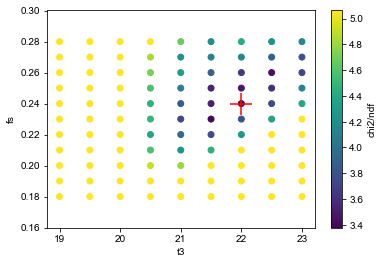

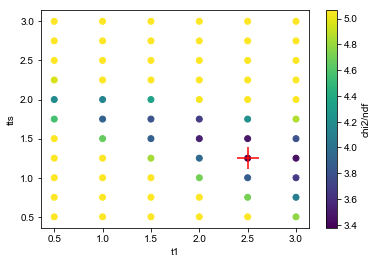

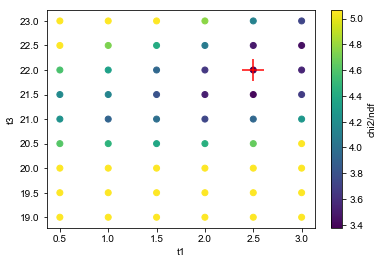

In [60]:
plot_all_slices(df)

In [43]:
minvalue(df)

{'chi2': 1.6769105838728187,
 'dset': 'nr',
 'e_max': 10,
 'e_min': 5,
 'fs': 0.22,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 1.5,
 't3': 21.5,
 'tts': 1.5}

In [45]:
e_bins_nr = [2, 5, 10, 15]
ddf = []

for e_min, e_max in zip(e_bins_nr[:-1], e_bins_nr[1:]):
    df = read_pickles(data_dir, 'nr_%02d_%02d' % (e_min, e_max))
    ddf.append(df)

Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.


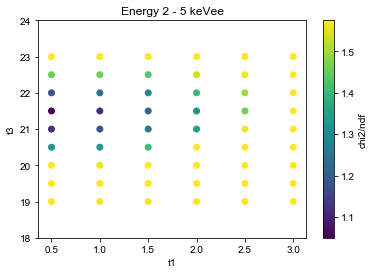

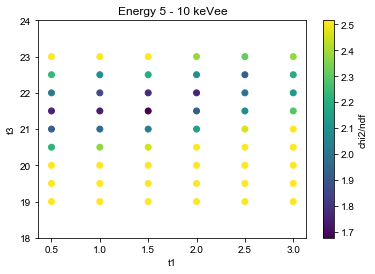

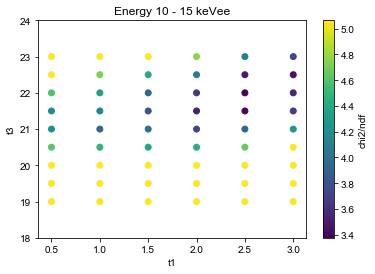

In [47]:
for i, df in enumerate(ddf):
    plt.ylim(18, 24)
    plt.title('Energy %d - %d keVee' % (df.iloc[0]['e_min'], df.iloc[0]['e_max']))
    parslice_2d(df, 't1', 't3', vmax=df['chi2'].min() * 1.5)

## ER low

In [334]:
ddf_er_l = read_and_combine_energy_bins(data_dir, ['er_l', 'er_l2'], [2, 5, 10, 20, 30, 50, 70])

Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 7290 datapoints from 7 files.
Read 2916 datapoints from 2 files.
Read 5103 datapoints from 5 files.
Read 13068 datapoints from 13 files.
Removing 3645 of 18171 items, already exist...
Read 6237 datapoints from 6 files.
Read 25200 datapoints from 25 files.
Removing 3564 of 31437 items, already exist...
Read 5400 datapoints from 5 files.
Read 25740 datapoints from 25 files.
Removing 1890 of 31140 items, already exist...
Read 5103 datapoints from 5 files.
Read 11880 datapoints from 11 files.
Removing 675 of 16983 items, already exist...


In [343]:
df = ddf_er_l[5]

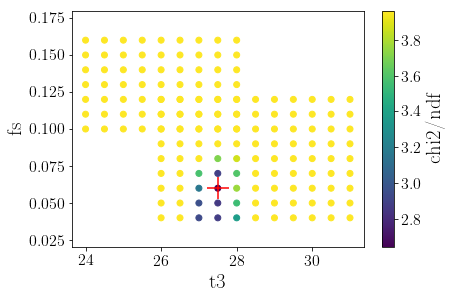

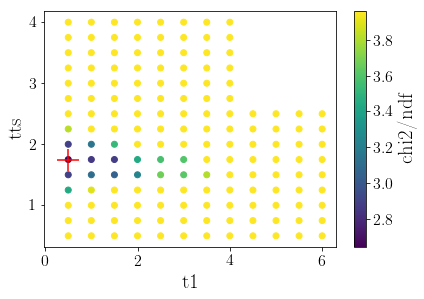

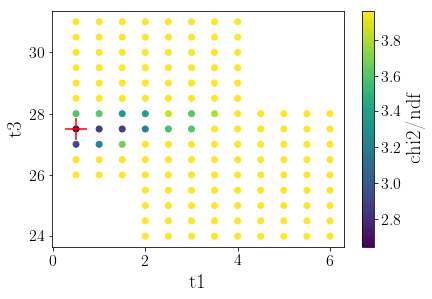

In [341]:
plot_all_slices(df)

In [344]:
minvalue(df)

{'chi2': 2.6418686676241347,
 'dset': 'er_l',
 'e_max': 70,
 'e_min': 50,
 'fs': 0.059999999999999998,
 'n_photons': 2000000,
 'stored_stat': True,
 't1': 0.5,
 't3': 27.5,
 'tts': 1.75}

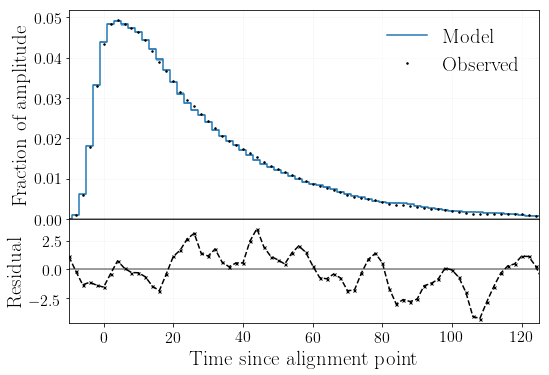

chi2 = 2.641869


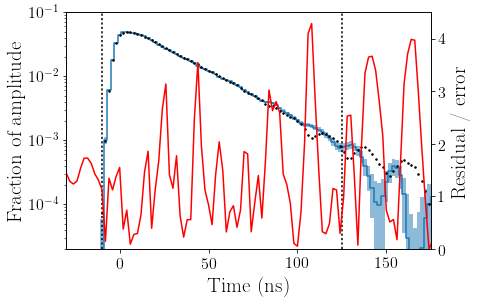

In [345]:
plot_model_manual(**minvalue(df, to_input=True))

## NR low

In [365]:
# for df in ddf_nr_l:
#     parslice_2d(df, 't3', 't1')

In [181]:
e_bins_nr = [2, 5, 10, 15]
ddf_nr_l = read_and_combine_energy_bins(data_dir, ['nr_l', 'nr_l2'], e_bins_nr)
#ddf_nr_l = read_energy_bins(data_dir, 'nr_l', e_bins_nr)

Read 6534 datapoints from 13 files.
Read 9373 datapoints from 3 files.
Removing 5437 of 15907 items, already exist...
Read 6534 datapoints from 13 files.
Read 9373 datapoints from 3 files.
Removing 5437 of 15907 items, already exist...
Read 6534 datapoints from 13 files.
Read 9373 datapoints from 3 files.
Removing 5437 of 15907 items, already exist...


In [32]:
df = ddf_nr_l[2]

In [33]:
df[df.chi2.isnull()]

,chi2,dset,e_max,e_min,fs,model,n_photons,spe_err,stored_stat,syst_err,t1,t3,tts,ydata,stored_stat_value
6534,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,0.50,NaN,NaN
6535,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,0.75,NaN,NaN
6536,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,1.00,NaN,NaN
6537,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,1.25,NaN,NaN
6538,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,1.50,NaN,NaN
6539,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,1.75,NaN,NaN
6540,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,2.00,NaN,NaN
6541,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.0,21.0,2.25,NaN,NaN
6542,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.5,21.0,0.50,NaN,NaN
6543,NaN,nr_l,5,2,0.24,NaN,500000,NaN,True,NaN,2.5,21.0,0.75,NaN,NaN


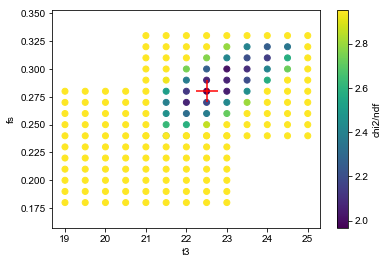

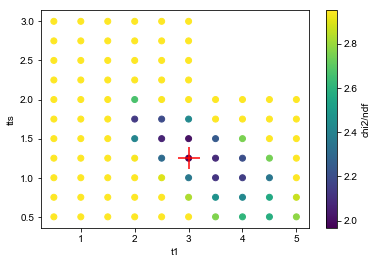

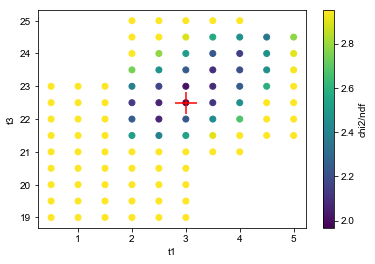

In [34]:
plot_all_slices(df)

In [423]:
ddf = read_energy_bins('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'nr_l', [2, 5, 10, 15])

Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.


## NR investigation

In [88]:
d = xams_data['nr']

In [96]:
xams_data.keys()

dict_keys(['nr', 'nr_l', 'bg_nr', 'er_l', 'er', 'er_0'])

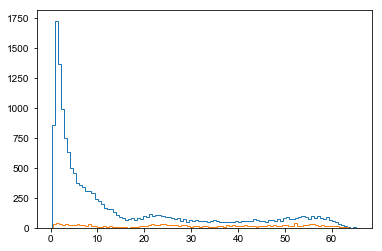

In [98]:
plt.hist(d['e_ces'], bins=100, histtype='step')
plt.hist(xams_data['bg_nr']['e_ces'], bins=100, histtype='step')
plt.show()

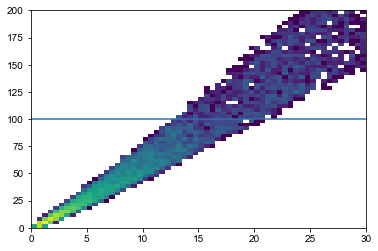

In [104]:
plt.hist2d(d['e_ces'], d['s1'], bins=60, norm=LogNorm(), range=((0, 30), (0, 200)))
plt.axhline(100)
plt.show()

Up to about 15 keVee is good.

In [112]:
p_nr = dict(n_photons = int(5e5), e_min = 10, e_max = 15, dset = 'nr', 
            # neglect_systematic = True, neglect_statistical = True,
            bootstrap_trials = 50,
            fs = 0.23, t3 = 22, t1 = 1.5, tts = 1.5
           )

{'t_min': -10.0, 'aft': 0.28, 'e_max': 15, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 10, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


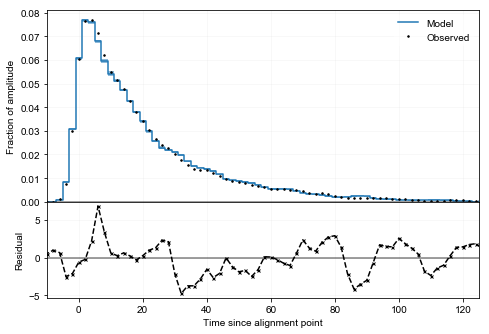

chi2 = 4.422413


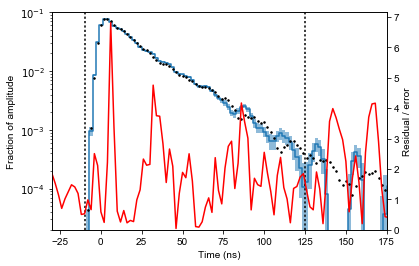

In [113]:
plot_model(**p_nr)

In [114]:
p_nr = dict(n_photons = int(5e5), e_min = 5, e_max = 10, dset = 'nr', 
            # neglect_systematic = True, neglect_statistical = True,
            bootstrap_trials = 50,
            fs = 0.23, t3 = 22, t1 = 1.5, tts = 1.5
           )

{'t_min': -10.0, 'aft': 0.28, 'e_max': 10, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 5, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


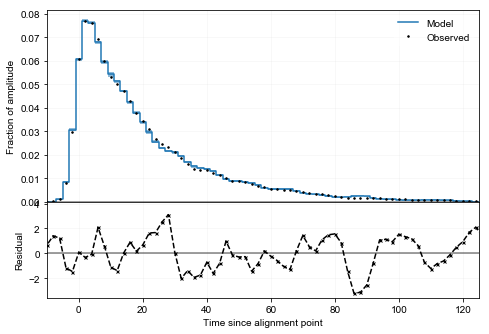

chi2 = 1.784474


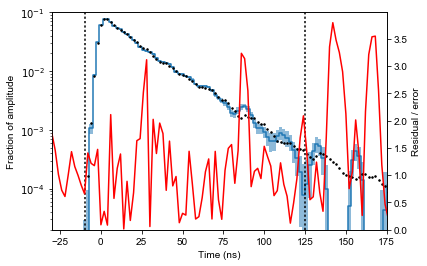

In [115]:
plot_model(**p_nr)

{'t_min': -10.0, 'aft': 0.28, 'e_max': 5, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 2, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


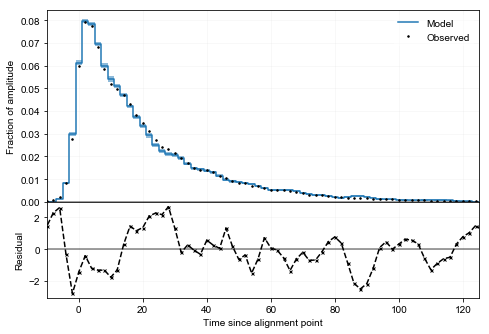

chi2 = 1.464754


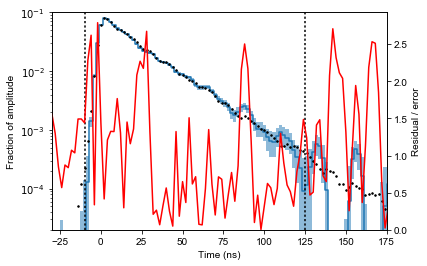

In [116]:
p_nr['e_min'] = 2
p_nr['e_max'] = 5
plot_model(**p_nr)

In [214]:
p = dict(
    # Dataset selection
    dset = 'er',
    e_min = 50,
    e_max = 70,
    
    # Speeding up computation
    neglect_systematic = True,
    neglect_statistical = False,
    bootstrap_trials = 10,
    
    # Fixed values
    t3 = 22.,
    t1 = 1.5,
    tts = 1.5,
    
    s1_model = 'recombination',
    fs = 0.1,
    tr = 200,
    f_r = 0.1,
    fs_r = 0.5,
)

In [215]:
# stored_stat_value = real_s1_wv_sigma(**p)

In [216]:
 p['stored_stat_value'] = stored_stat_value

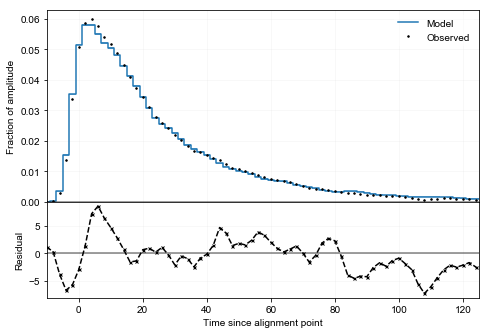

chi2 = 10.334201


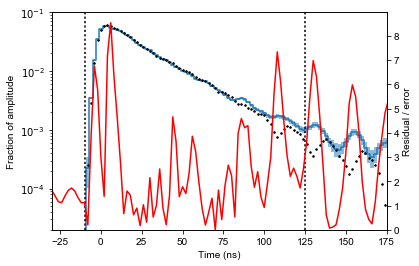

In [217]:
plot_model(verbose=False, **p)

# Process all four-fit data

### Functions

In [ ]:
def min_per_e(ddf, dset, chi2_max = None, chi2_max_factor = None):
    '''
    Get the parameters where chi2 is minimal up to a certain chi2 value.
    This gives the statistical error
    '''
    d = xams_data[dset]
    x = []

    for i, df in enumerate(ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        if chi2_max is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max)
        elif chi2_max_factor is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max_factor) 
        else:
            raise ValueError('Configuration not understood.')
        for key in ['t3', 't1', 'fs', 'tts']:
            fit[key] = np.mean(mins[key])
            fit['d' + key] = np.std(mins[key])
        x.append(fit)
    x = pd.DataFrame(x)
    return x

In [ ]:
def min_per_e_syst(ddf, dset, settings):
    '''
    Get the values of paramters where chi2 is minimal if parameters are varied. 
    '''
    all_mins = []
    for i, df in enumerate(ddf):
        mins = scan_settings_and_get_min(settings, df)
        all_mins.append(mins)
        
    with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'wb') as f:
        pickle.dump(all_mins, f)
    return all_mins

In [166]:
def process_mins(ddf, dset, mins_per_e = None):
    '''Requires a list of dataframes containing the minimum values.'''
    if mins_per_e is None:
        with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'rb') as f:
            mins_per_e = pickle.load(f)
            print('Read %d settings in %d bins from file.' % (len(mins_per_e[0]), len(mins_per_e)))
    d = xams_data[dset]
    x = []
    for mins, df in zip(mins_per_e, ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        for key in ['t3', 't1', 'fs', 'tts', 'chi2']:
            fit[key] = np.mean(mins[key])
            fit['d' + key] = np.std(mins[key])
        x.append(fit)
    x = pd.DataFrame(x)
    return x

In [167]:
def process_and_combine_syst_and_stat(ddf, dset, chi2_max_factor, verbose = False):
    x_stat = min_per_e(ddf, dset, chi2_max_factor = chi2_max_factor)
    x_syst = process_mins(ddf, dset) # assuming all from file
    # COMBINE ALL
    x = []
    for i in range(len(x_stat)):
        fit = {}
        for key in ['e', 'de', 'chi2', 'dchi2']:
            fit[key] = x_syst[key].values[i]
        minval = minvalue(ddf[i])
        for key in ['t3', 't1', 'fs', 'tts']:
            # For the minimum, just take the value that is the minimum
            fit[key] = minval[key]
            fit['d' + key + '_syst'] = x_syst['d' + key].values[i]
            fit['d' + key + '_stat'] = x_stat['d' + key].values[i]
            fit['d' + key] = np.sqrt(fit['d' + key + '_syst']**2 + fit['d' + key + '_syst']**2)
        x.append(fit)
    return pd.DataFrame(x)

### Read

In [151]:
# Energy bins
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
e_bins_nr = [2, 5, 10, 15]

In [152]:
# Reading the dataframes
ddf_er = read_energy_bins(data_dir, 'er', e_bins_er)
ddf_er_l = read_and_combine_energy_bins(data_dir, ['er_l', 'er_l2'], e_bins_er)
ddf_nr = read_energy_bins(data_dir, 'nr', e_bins_nr)
ddf_nr_l = read_energy_bins(data_dir, 'nr_l', [2, 5, 10, 15])

Read 6237 datapoints from 12 files.
Read 6237 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 5103 datapoints from 10 files.
Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 7290 datapoints from 7 files.
Read 2916 datapoints from 2 files.
Read 5103 datapoints from 5 files.
Read 13068 datapoints from 13 files.
Removing 3645 of 18171 items, already exist...
Read 6237 datapoints from 6 files.
Read 25200 datapoints from 25 files.
Removing 3564 of 31437 items, already exist...
Read 5400 datapoints from 5 files.
Read 25740 datapoints from 25 files.
Removing 1890 of 31140 items, already exist...
Read 5103 datapoints from 5 files.
Read 11880 datapoints from 11 files.
Removing 675 of 16983 items, already exist...
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 65

### Systematic errors

In [153]:
settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], 
                                  [-12, 110, 0], [-6, 140, 2e-4], [2, 5, 1e-4], block_size=100000)

Loaded 84 settings.


In [156]:
for ddf, dset in zip([ddf_er, ddf_er_l, ddf_nr, ddf_nr_l], ['er', 'er_l', 'nr', 'nr_l']):
    if dset in ['er', 'nr_l']:
        print('Skipping dset %s ...' % dset)
        continue
    print('Now processing dset %s' % dset)
    systscan = min_per_e_syst(ddf_er, 'er', settings)


  0%|          | 0/84 [00:00<?, ?it/s]

Skipping dset er ...
Now processing dset er_l



 77%|███████▋  | 65/84 [02:13<00:40,  2.13s/it]

KeyboardInterrupt: 

### Combine all

In [157]:
chi2_max_factor = 1.1

In [168]:
x_er = process_and_combine_syst_and_stat(ddf_er, 'er', chi2_max_factor = chi2_max_factor)
# x_er_l = process_and_combine_syst_and_stat(ddf_er_l, 'er_l', chi2_max_factor = chi2_max_factor)
# x_nr = process_and_combine_syst_and_stat(ddf_nr, 'nr', chi2_max_factor = chi2_max_factor)
# x_nr_l = process_and_combine_syst_and_stat(ddf_nr_l, 'nr_l', chi2_max_factor = chi2_max_factor)

Selected 23 values with chi2 ranging from 1.03 to 1.13...
Selected 10 values with chi2 ranging from 0.99 to 1.09...
Selected 15 values with chi2 ranging from 1.57 to 1.72...
Selected 11 values with chi2 ranging from 2.06 to 2.27...
Selected 16 values with chi2 ranging from 2.49 to 2.73...
Selected 5 values with chi2 ranging from 2.47 to 2.70...
Read 84 settings in 6 bins from file.


In [162]:
# x_er = min_per_e(ddf_er, 'er', chi2_max_factor=chi2_max_factor)
x_er_l = min_per_e(ddf_er_l, 'er_l', chi2_max_factor=chi2_max_factor)
x_nr = min_per_e(ddf_nr, 'nr', chi2_max_factor=chi2_max_factor)
x_nr_l = min_per_e(ddf_nr_l, 'nr_l', chi2_max_factor=chi2_max_factor)

Selected 22 values with chi2 ranging from 1.49 to 1.64...
Selected 9 values with chi2 ranging from 1.17 to 1.28...
Selected 6 values with chi2 ranging from 1.31 to 1.43...
Selected 9 values with chi2 ranging from 1.49 to 1.64...
Selected 18 values with chi2 ranging from 1.94 to 2.12...
Selected 5 values with chi2 ranging from 2.64 to 2.89...
Selected 4 values with chi2 ranging from 1.05 to 1.13...
Selected 5 values with chi2 ranging from 1.68 to 1.78...
Selected 19 values with chi2 ranging from 3.38 to 3.71...
Selected 34 values with chi2 ranging from 1.25 to 1.38...
Selected 4 values with chi2 ranging from 1.99 to 2.11...
Selected 4 values with chi2 ranging from 3.77 to 4.03...


# Pretty plots

## Eight panel plot

In [130]:
from matplotlib import gridspec

In [131]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


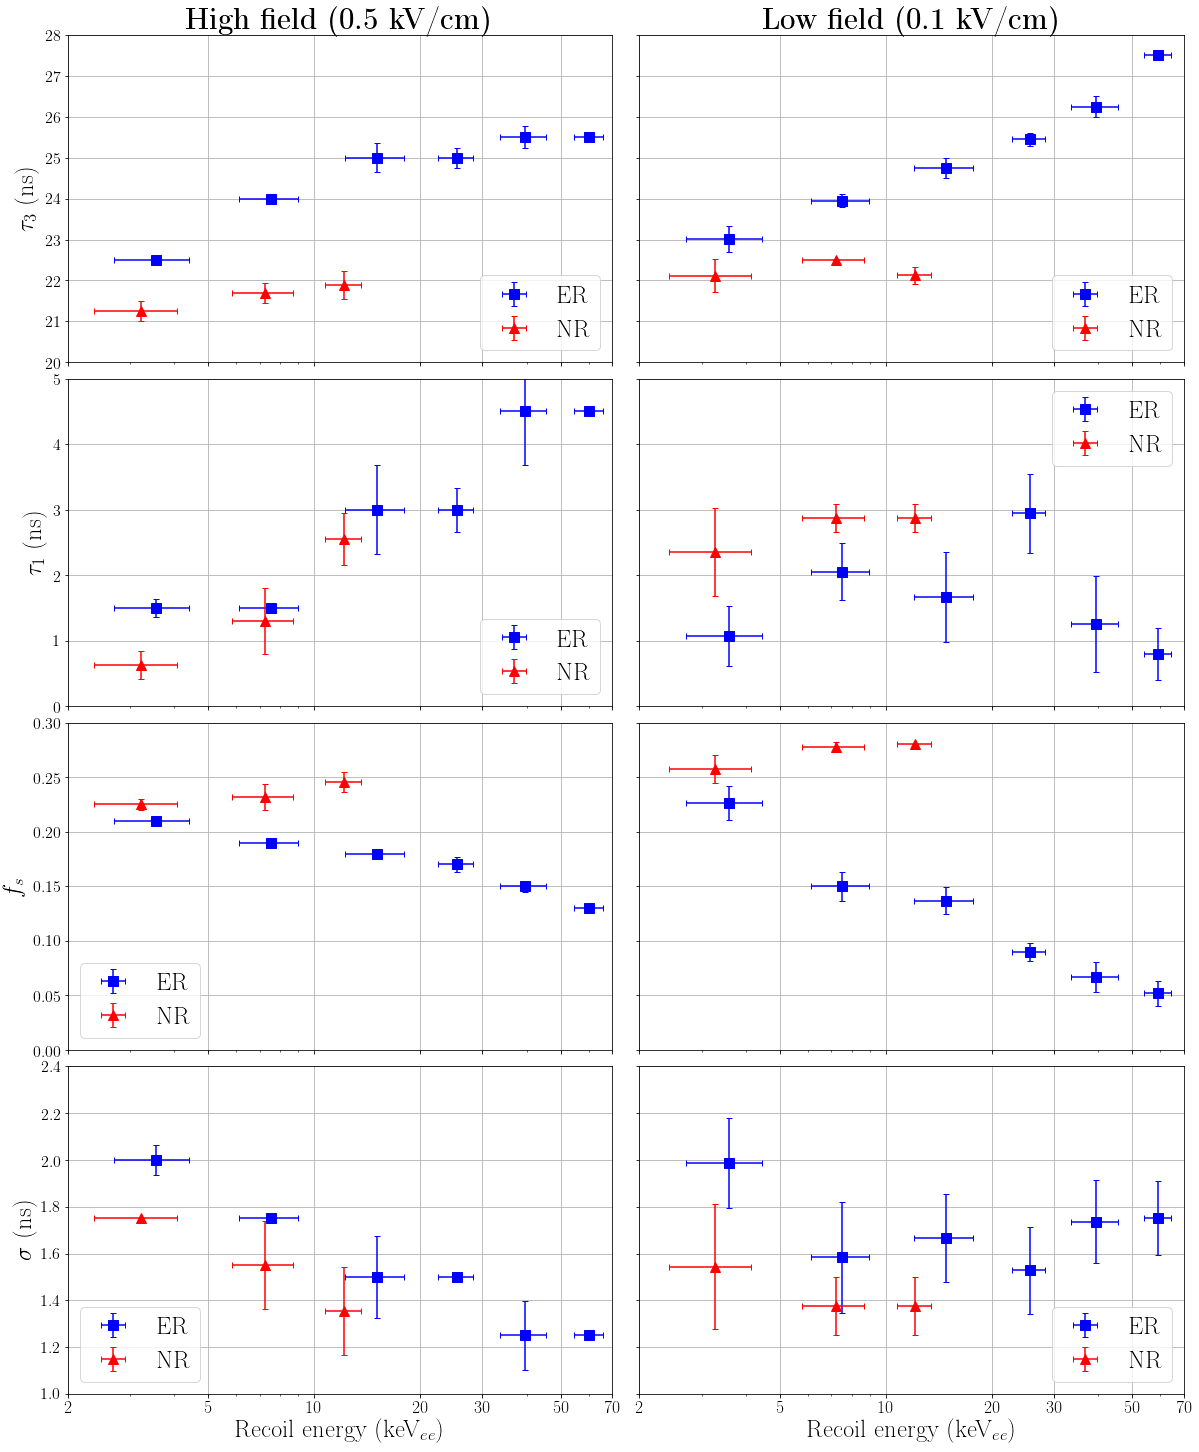

In [163]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

f = plt.figure(figsize=(20,25))
gs = gridspec.GridSpec(4, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# Set grid and x limits
for ax in axes:
    ax.set_xlim(2, 70)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xtick) for xtick in xticks])
    ax.grid()
    

for ax in axes:
    if ax == ax6 or ax==ax7:
        continue
    ax.set_xticklabels([])

# Plot titles
ax0.set_title(r'\bf High field (0.5 kV/cm)')
ax1.set_title(r'\bf Low field (0.1 kV/cm)')

# x-axis titles
for ax in [ax6, ax7]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')

# Turn off y-axis ticks for 
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{3}$ (ns)")
ax2.set_ylabel(r"$\tau_{1}$ (ns)")
ax4.set_ylabel(r'$f_s$')
ax6.set_ylabel(r'$\sigma$ (ns)')

for x, l, c, marker in zip([x_er, x_nr], ['ER', 'NR'], ['blue', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax0, ax2, ax4, ax6]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = x['d' + ypar], 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_er_l, x_nr_l], ['ER', 'NR'], ['blue', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax1, ax3, ax5, ax7]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = x['d' + ypar], 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    ax.set_ylim(20, 28)
for ax in [ax2, ax3]:
    ax.set_ylim(0, 5)
for ax in [ax4, ax5]:
    # Singlet fraction
    ax.set_ylim(0., 0.30)
for ax in [ax6, ax7]:
    # tts
    ax.set_ylim(1, 2.4)
    
for ax in axes:
    if ax in [ax0, ax1, ax2, ax7]:
        ax.legend(loc='lower right')
    if ax in [ax4, ax6]:
        ax.legend(loc='lower left')
    if ax in [ax3]:
        ax.legend(loc='upper right')
    
# plt.savefig('/home/erik/win/notes/giant_plotfig.pdf', bbox_inches='tight')

## Fit example

This requires the four-fit data to have been read, and the ddf from `Read all four-fit data` 

In [53]:
df = ddf_er[2]

In [155]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [208]:
import matplotlib as mpl
def fancyplot(**params):
    gridalpha = 0.3
    
    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    plt.sca(ax1)
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[1]._legmarker.set_markersize(8)
    plt.ylim(0, None)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    
    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
#     plt.xlim(-12, 150)
#     for _l in (params['t_min'], params['t_max']):
#         plt.axvline(_l)
    plt.xlim(params['t_min'], params['t_max'])

    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    plt.gcf().subplots_adjust(0,0,1,1,0,0)
    ax1.get_yaxis().set_label_coords(-0.067 ,0.5)
    # ax2.get_yaxis().set_label_coords(0, 0.5)
    


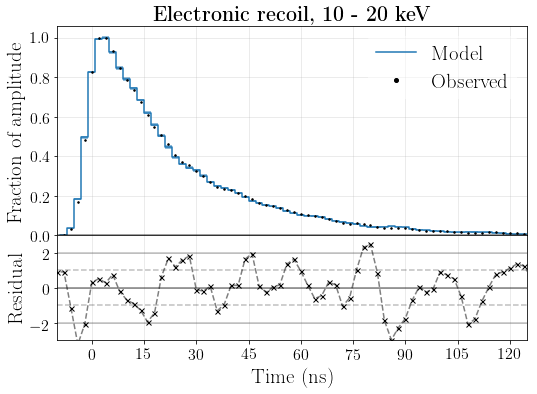

In [209]:
fancyplot(**minvalue(df, to_input=True))
plt.savefig('pulsefit.pdf', bbox_inches='tight')

In [298]:
def fancylong(**params):
    gridalpha = 0.3
    h_bottom = 0.15
    h_top = (0.8 - h_bottom)/2

    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)
    xlim = (params['t_min'], params['t_max'])

    plt.figure(figsize = (6.531496194824962, 2* 4.3543307965499745)) # Double height figure
    
    #### FRAME 1
    frame1=plt.gcf().add_axes((.1,0.1 + h_top + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid', label='Uncertainty')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame1.get_xticklabels(), visible=False)
    plt.axhline(0, c='k', alpha=0.5)
    handles, labels =  frame1.get_legend_handles_labels()
    labels = [labels[0], labels[2], labels[1]]
    handles = [handles[0], handles[2],handles[1]]
    leg = plt.legend(handles, labels, loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[2]._legmarker.set_markersize(8)
    plt.ylim(0, 1.1)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.yticks(np.arange(0.2, 1.2, 0.2))

    plt.xlim(xlim)
    #### FRAME 2
    frame2=plt.gcf().add_axes((.1,0.1 + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame2.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    plt.yscale('log')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    plt.xlim(xlim)
    plt.xticks(np.arange(0, 140, 20))
    plt.ylim(5e-4, 1.2)
    frame3=plt.gcf().add_axes((.1,.1,.8, h_bottom))
    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    plt.xlim(xlim)
    plt.yticks([-2, -1, 0, 1, 2])
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    
    frame2.get_yaxis().set_label_coords(-0.10 , 1)
    frame3.get_yaxis().set_label_coords(-0.10 , 0.5)
    print(params['chi2'])

1.56593348767


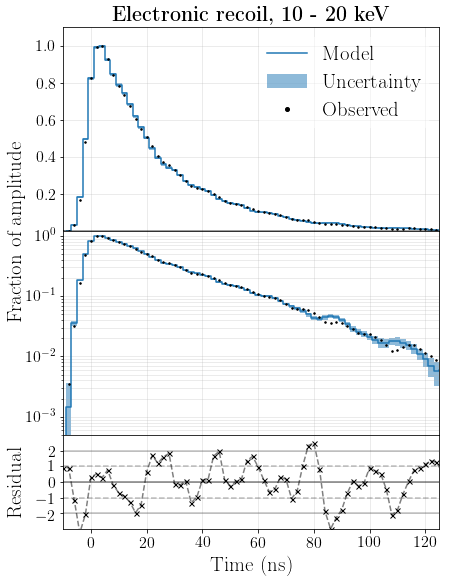

In [299]:
fancylong(**minvalue(df, to_input=True))
# plt.savefig('pulsefit.pdf', bbox_inches='tight')

## Chi2 evolution

In [173]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


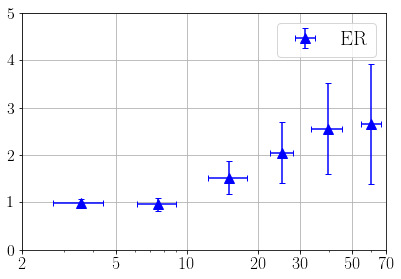

In [180]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

for x, l, c in zip([x_er], ['ER'], ['blue']):
    plt.errorbar(x['e'], x['chi2'], xerr=x['de'], yerr=x['dchi2'],
                 label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)
    
plt.xlim(2, 70)
plt.xscale('log')
plt.xticks(xticks)
plt.gca().set_xticklabels([str(xtick) for xtick in xticks])
plt.grid()
plt.ylim(0, 5)
plt.legend()
plt.show()

# Improvements (R&D section)

## Interpretation of chi2 thing

In [450]:
ndf = 20
offset = 2.5
sigma = 2

def get_chi2(ndf, sigma, f_real, preal, f_fit, x0, xreal, plot=False, ret = 'ratio'):    
    t       = np.linspace(0, 100, ndf)
    err_est = np.ones(ndf) * sigma
    y = f_real(t, **preal)
    dy = np.random.normal(loc=0, scale=sigma, size=ndf)
    y = y + dy
    
    if plot:
        plt.plot(t, y)
    truefit = np.sum(((y - f_fit(t, xreal)) / err_est)**2) / ndf
    if ret == 'truevalue':
        return truefit
    
    optres = scipy.optimize.minimize(lambda x : np.sum(((y - f_fit(t, x)) / err_est)**2) / ndf, x0).fun
    return truefit / optres


In [387]:
(126 + 2) /2

64.0

In [388]:
def const(x, a):
    return a

In [413]:
get_chi2(64, 1, const, {'a':1}, const, 2)

2.2002291566520271

In [435]:
chi2s = [get_chi2(64, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.015860


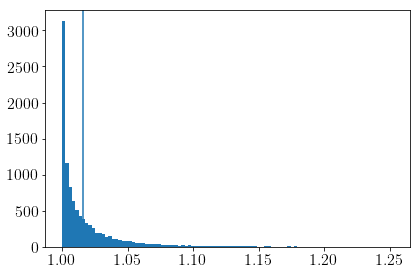

In [436]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [454]:
chi2s = [get_chi2(6, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.241256


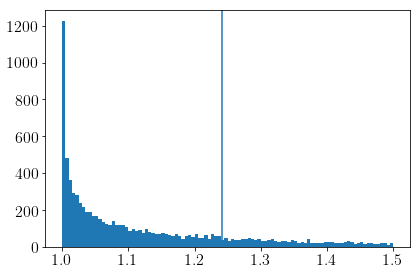

In [456]:
plt.hist(chi2s, bins=100, range=(1, 1.5))
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [422]:
def const_w_osc(x, a, period, amp):
    return a + amp * np.cos(2 * np.pi * x/period)

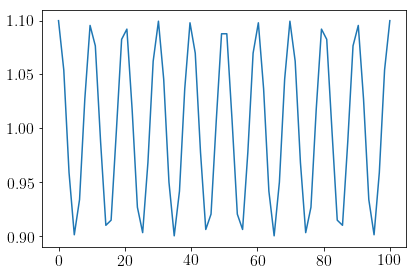

In [423]:
t = np.linspace(0, 100, 64)
plt.plot(t, const_w_osc(t, 1, 10, 0.1))

1.0000372882850095

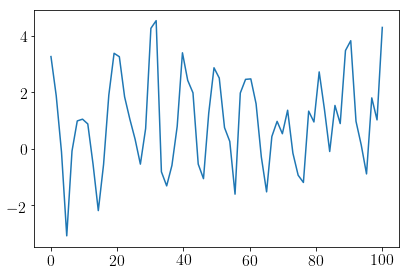

In [443]:
get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, plot=True)

In [437]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=0.1), const, 2, 1) for _ in range(10000)]

Cutoff at 1.015604


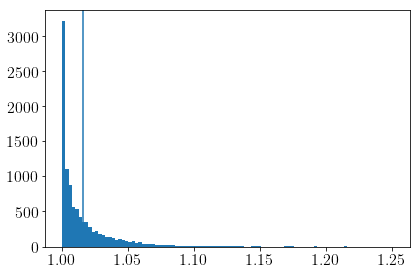

In [438]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [457]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=1.), const, 2, 1) for _ in range(10000)]

Cutoff at 1.010703


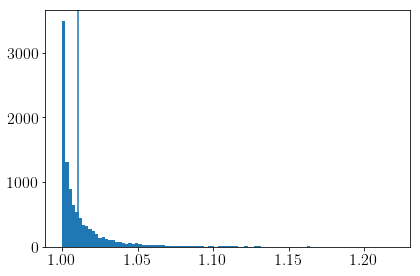

In [458]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [444]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1) for _ in range(10000)]

Cutoff at 1.005576


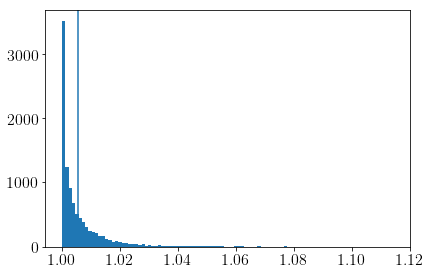

In [445]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [451]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, ret='truevalue') for _ in range(10000)]

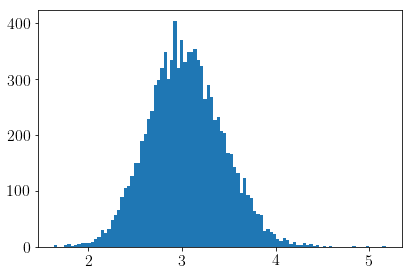

In [453]:
plt.hist(chi2s, bins=100)
plt.show()

## Data-driven spe error

In [61]:
df = read_pickles(data_dir, 'er_e_10_20_newer_spe')

Read 5103 datapoints from 25 files.


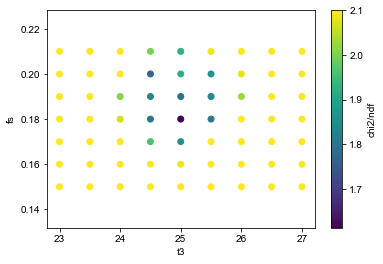

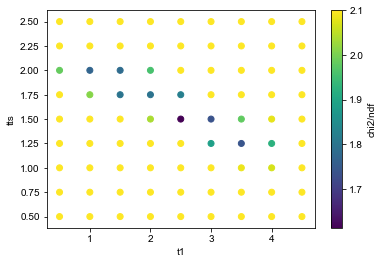

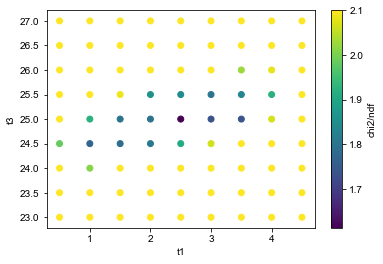

In [62]:
plot_all_slices(df, vmax=2.1)

In [63]:
minvalue(df)

{'chi2': 1.6126650051442681,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.17999999999999999,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 2.5,
 't3': 25.0,
 'tts': 1.5}

In [67]:
popt = minvalue(df, to_input=True)

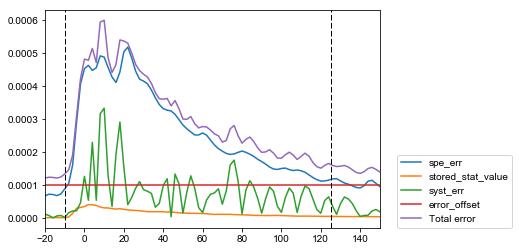

Chi2 in peak: (-10 to 30 ns): 1.93
Chi2 in tail: (30 to 125 ns): 1.48
Chi2 total: 1.61


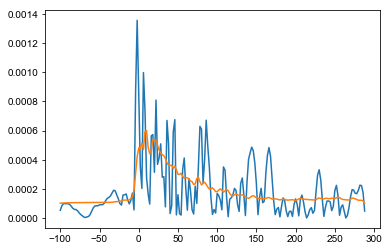

In [68]:
check_errors(**popt)

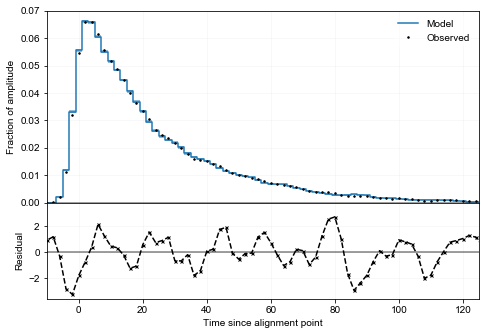

chi2 = 1.612665


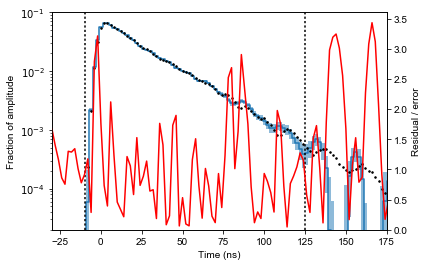

In [69]:
plot_model_manual(**popt)

In [80]:
mins = get_some_minima(df, 100, threshold=popt['chi2'] + 0.25)

Selected 15 values with chi2 ranging from 1.61 to 1.86...


In [81]:
print_minima(mins)

Giving the standard deviation for 15 points...
fs = 0.187 +- 0.009
t3 = 25.000 +- 0.365
t1 = 2.333 +- 0.745
tts = 1.650 +- 0.220
Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for 15 points...
fs = 0.180 + 0.010 - 0.020
t3 = 25.000 + 0.500 - 0.500
t1 = 2.500 + 1.500 - 1.000
tts = 1.500 + 0.250 - 0.500


## Quad errors

In [124]:
p

{'chi2': 0.15445825612565142,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.19,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 1.5,
 't3': 24.5,
 'tts': 1.75}

In [125]:
model, sigma_syst, spe_err = s1_models_error(**p)

In [128]:
p['stored_stat_value'] = real_s1_wv_sigma(**p)

In [129]:
default_params['stored_stat_value'] = p['stored_stat_value']

In [130]:
# Build dicts
p = deepcopy(minvalue(df))
p1 = deepcopy(p)
p2 = deepcopy(p)

# Extract these parameters only once
# default_params['stored_stat_value'] = real_s1_wv_sigma(**p)
ydata, _ = real_s1_wv(**p)

# Now for p1...
p1['quad_adding'] = False
model, sigma_syst, spe_err = s1_models_error(**p1)
p1['ydata'], p1['model'], p1['syst_err'], p1['spe_err'] = (ydata, model, syst_err, spe_err)
p1['chi2'] = gof_manual(**p1)

# Now for p2...
p2['quad_adding'] = True
model, sigma_syst, spe_err = s1_models_error(**p2)
p2['ydata'], p2['model'], p2['syst_err'], p2['spe_err'] = (ydata, model, syst_err, spe_err)
p2['chi2'] = gof_manual(**p2)


gof=0.09465571363944048, fs=0.19, t1=1.5, t3=24.5, tts=1.75
gof=1.7652950812151533, fs=0.19, t1=1.5, t3=24.5, tts=1.75


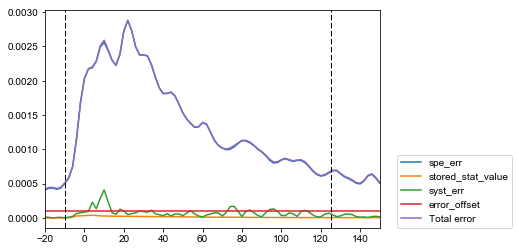

Chi2 in peak: (-10 to 30 ns): 0.13
Chi2 in tail: (30 to 125 ns): 0.08
Chi2 total: 0.09


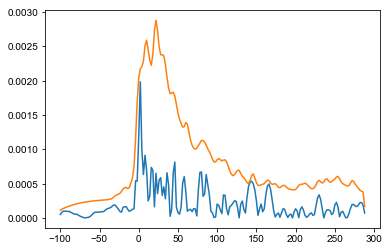

In [137]:
check_errors(**p1)

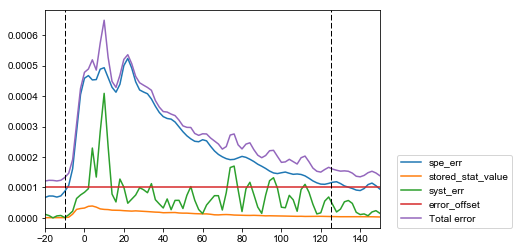

Chi2 in peak: (-10 to 30 ns): 1.90
Chi2 in tail: (30 to 125 ns): 1.71
Chi2 total: 1.77


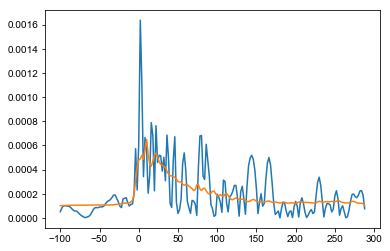

In [138]:
check_errors(**p2)

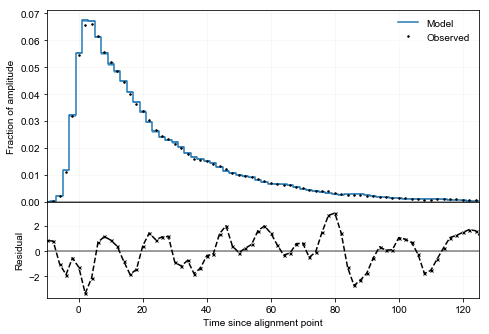

chi2 = 1.765295


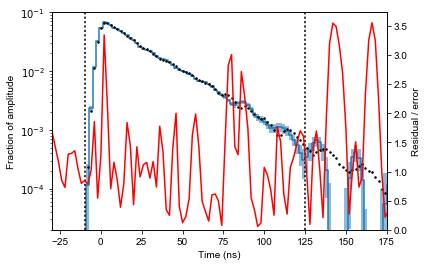

In [140]:
plot_model_manual(**p2)

In [ ]:
p1 = deepcopyy(p)

In [126]:
chi2 = gof_manual(ydata, model, syst_err, spe_err, **p)

array([  5.20008159e-05,   8.47355915e-05,   1.02297844e-04,
         1.01559138e-04,   9.87126241e-05,   9.81849245e-05,
         9.37794639e-05,   8.21374492e-05,   6.78890058e-05,
         6.17913444e-05,   6.12944478e-05,   5.41079202e-05,
         4.03611282e-05,   2.76511637e-05,   1.85283561e-05,
         9.43267479e-06,  -2.71787493e-07,  -3.95600837e-06,
        -3.84434292e-06,  -1.25557692e-05,  -3.69324599e-05,
        -6.39809951e-05,  -7.80271292e-05,  -7.77174749e-05,
        -7.68658021e-05,  -8.45702340e-05,  -8.96419877e-05,
        -8.99425294e-05,  -9.82332813e-05,  -1.14727921e-04,
        -1.29448630e-04,  -1.38047585e-04,  -1.47496811e-04,
        -1.65889237e-04,  -1.86150812e-04,  -1.85635908e-04,
        -1.57807243e-04,  -1.28605697e-04,  -1.26729894e-04,
        -1.58870012e-04,  -1.99186883e-04,  -2.19175853e-04,
        -2.14603853e-04,  -1.82281583e-04,  -1.42351299e-04,
        -1.25709451e-04,   9.84058905e-05,   2.29536223e-03,
         1.17664296e-02,

## Shift per s1

In [220]:
s1_waveforms, s1_waveforms_error, time_matrix, t_shift = simulate_s1_pulse(n_photons = int(1e6), max_shift = 10)

(-10, 20)

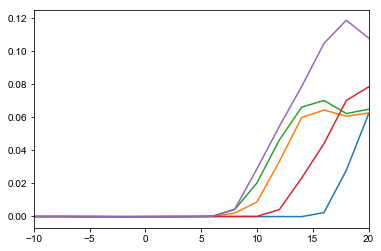

In [214]:
for i in range(5):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

(-10, 20)

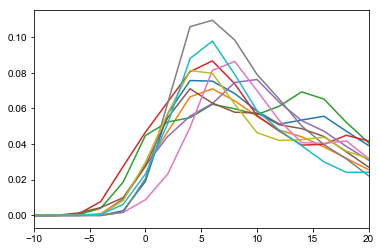

In [221]:
for i in range(10):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

(-10, 20)

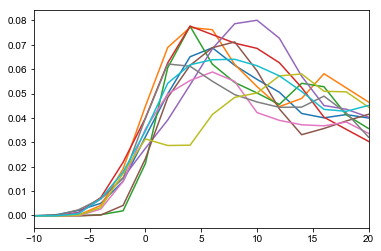

In [219]:
for i in range(10):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

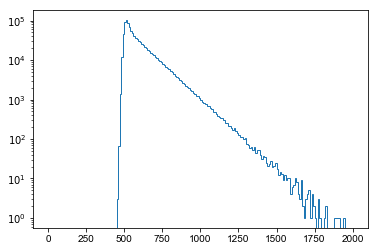

In [197]:
plt.hist(bla, range=(0, 2000), histtype='step', bins=200)
plt.yscale('log')
plt.show()

In [230]:
p = deepcopy(minvalue(df, to_input=False, keep_only_stored=True))

{'s1_model': 'two_exp', 'e_min': 10, 'tr': 15, 'neglect_statistical': False, 'max_shift': 10, 'dset': 'er', 'aft': 0.28, 'f_r': 0.0, 't3': 25.0, 'fs': 0.17999999999999999, 'tts': 1.5, 'e_max': 20, 'n_photons': 500000, 'error_offset': 0.0001, 't_max': 125.0, 't_min': -10.0, 't1': 2.5, 'quad_adding': True, 'stored_stat_value': array([  3.07804535e-08,   5.92180795e-08,   7.09834496e-08,
         5.14710958e-08,   3.01168574e-08,   4.08173680e-08,
         3.73462117e-08,   3.32615231e-08,   7.52955756e-08,
         1.15710767e-07,   1.19748888e-07,   1.34387793e-07,
         1.35912606e-07,   1.62253800e-07,   1.85788174e-07,
         1.86828163e-07,   2.14834888e-07,   1.93726183e-07,
         1.94519866e-07,   2.01598222e-07,   1.80019982e-07,
         1.71336610e-07,   1.78384911e-07,   1.94799460e-07,
         2.41142740e-07,   2.43048638e-07,   2.24170074e-07,
         1.95812491e-07,   2.10763441e-07,   2.28679693e-07,
         2.33560324e-07,   2.06717925e-07,   1.95629026e-07,
  

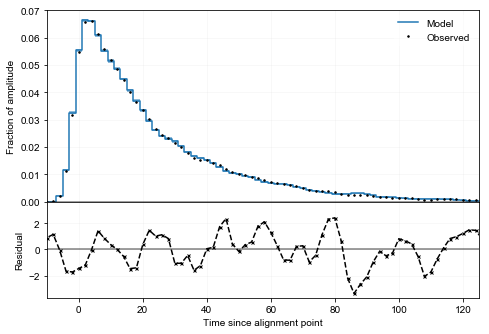

chi2 = 1.607674


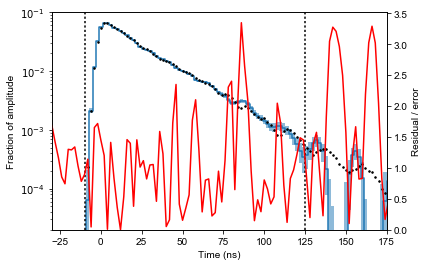

In [232]:
plot_model(**p)

## Sub-sample alignment

This has been implemented, done now.

## Statistics...

This part may be outdated after the error redefinition

In [73]:
gofs_list = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=4.847686336182956, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.893724830132279, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.6621421313708025, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.960056160807073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.036084011427087, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.435783839662097, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.426565338782284, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.506808589426186, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.377088315327442, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!


In [88]:
nph_scan = [int(2e5), int(4e5), int(2e6), int(4e6)]

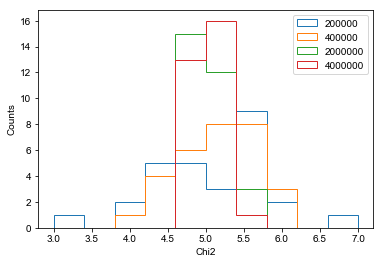

In [89]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(gofs, histtype = 'step', bins=10, range=(3,7), label='%d' % l)
plt.xlabel('Chi2')
plt.ylabel('Counts')
plt.legend()
plt.show()

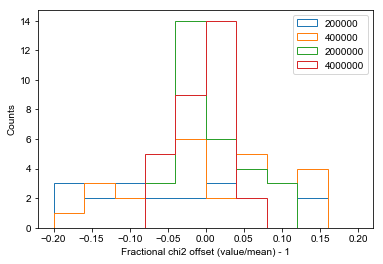

In [90]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(np.array(gofs) / np.mean(gofs) - 1, histtype = 'step', bins=10, range=(-.2,.2), label='%d' % l)
plt.xlabel('Fractional chi2 offset (value/mean) - 1')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [91]:
np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1)

array([ 0.18106677,  0.10032424,  0.04895351,  0.0351447 ])

In [92]:
gofs_list_stat = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
popt['neglect_systematic'] = False
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list_stat.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=2.994595859402191, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.7180867413599614, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.581299280602138, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3044093119377864, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=3.87797057226319, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3584730945375254, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.9466589522782445, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.2913916890875003, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.8378287717356594, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat paramet

In [94]:
np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1)

array([ 0.26617473,  0.19006954,  0.06307608])

#### The money plot

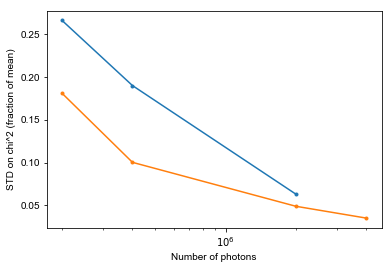

In [125]:
plt.plot(nph_scan, np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1), marker='.')
plt.plot(np.concatenate([nph_scan, [int(4e6)]]), np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1), marker='.')
plt.xscale('log')
plt.xlabel('Number of photons')
plt.ylabel('STD on chi^2 (fraction of mean)')

### Number of bootstrap trials

In [129]:
popt['n_photons'] = int(1e6)
popt['stored_stat'] = False

boot_scan = [20, 100, 200, 1000]
boots = []
for bt in boot_scan:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])


20
gof=1.934865562922848, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.294249914987514, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.897927975499547, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.20651953781785, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3404212287590673, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.824898948772344, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8283130743557883, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.452338891592939, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0894702055698833, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.5820449784985073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.9172095355070393, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.789504337155653, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4301882420563343, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.544293321063236, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.240761883540313, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4581112505576193, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3309261638355525, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=

KeyboardInterrupt: 

In [135]:
for bt in [400]:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])

400
gof=2.169790799650517, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0958783567618977, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0437041529418414, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.189776783448054, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.335455337573744, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.016523940034678, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.957150616151253, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2426380687513316, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0268897915146216, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7702937134946244, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2007160689622935, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8613155479428471, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.138296685063111, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0494810091269486, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7838359820359413, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.880781820935462, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.299482036700427, fs=0.19, t1=2.0, t3=25.0, tts=1.75
g

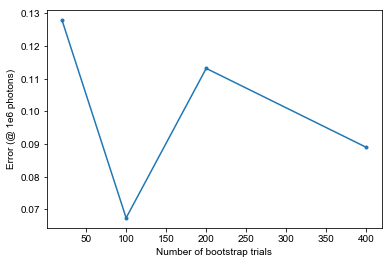

In [136]:
plt.plot([20, 100, 200, 400], np.std(boots, axis=1) / np.mean(boots, axis=1), marker='.')
plt.xlabel('Number of bootstrap trials')
plt.ylabel('Error (@ 1e6 photons)')

It looks like at 1M photons, the number of bootstrap trials is not so important as long as it is high enough (>= 100)